# Classifying Business Documents using Deep Learning
## IBM Coursera Advanced Data Science Capstone - Model Building

## Sumudu Tennakoon


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 16 2019

@author: Sumudu Tennakoon
@licence:Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)
"""

import sys
import argparse
import os
import traceback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import PIL
from PIL import Image as PImage, ImageDraw, ImageEnhance, ImageFilter, ImageChops, ImageOps

# 1. Processing the files list

## 1.1 Setting File Paths

In [2]:
DataRootFolder = r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip\images'

## 1.2 Load image label lookup tables

In [3]:
TestFiles = pd.read_csv(r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip\labels\test.txt', sep=' ', header=None)
TrainFiles = pd.read_csv(r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip\labels\train.txt', sep=' ', header=None)
ValidateFiles = pd.read_csv(r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip\labels\val.txt', sep=' ', header=None)
FilePaths = TrainFiles.append(TestFiles, ignore_index=True)
FilePaths = FilePaths.append(ValidateFiles, ignore_index=True)
FilePaths.columns=['FilePath', 'ClassNumber']
print('File Count', len(FilePaths.index))
print(FilePaths.head())

File Count 400000
                                           FilePath  ClassNumber
0               imagesq/q/o/c/qoc54c00/80035521.tif           15
1              imagese/e/w/c/ewc23d00/513280028.tif            1
2             imagesw/w/b/t/wbt26e00/2053453161.tif            7
3  imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif           10
4        imageso/o/e/x/oex80d00/522787731+-7732.tif            3


## 1.3 Get dataset counts

In [4]:
print(FilePaths.groupby(by='ClassNumber')['ClassNumber'].count())

ClassNumber
0     25000
1     25000
2     25000
3     25000
4     25000
5     25000
6     25000
7     25000
8     25000
9     25000
10    25000
11    25000
12    25000
13    25000
14    25000
15    25000
Name: ClassNumber, dtype: int64


## 1.4 Assign text labels

In [5]:
ClassLabelLookup=pd.DataFrame(data=[(0  , 'letter', 1)
                                ,(1 , 'form', 0)
                                ,(2 , 'email', 0)
                                ,(3 , 'handwritten', 1)
                                ,(4 , 'advertisement', 1)
                                ,(5 , 'scientific report', 0)
                                ,(6 , 'scientific publication', 1)
                                ,(7 , 'specification', 0)
                                ,(8 , 'file folder', 0)
                                ,(9 , 'news article', 0)
                                ,(10, 'budget', 0)
                                ,(11, 'invoice', 1)
                                ,(12, 'presentation', 0)
                                ,(13, 'questionnaire', 0)
                                ,(14, 'resume', 1)
                                ,(15, 'memo', 0)], columns=['ClassNumber','ClassLabel', 'UseToModel'])
FilePaths = FilePaths.merge(ClassLabelLookup, on='ClassNumber', how='left' )
#Preview dataset
print(FilePaths.head())

                                           FilePath  ClassNumber  \
0               imagesq/q/o/c/qoc54c00/80035521.tif           15   
1              imagese/e/w/c/ewc23d00/513280028.tif            1   
2             imagesw/w/b/t/wbt26e00/2053453161.tif            7   
3  imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif           10   
4        imageso/o/e/x/oex80d00/522787731+-7732.tif            3   

      ClassLabel  UseToModel  
0           memo           0  
1           form           0  
2  specification           0  
3         budget           0  
4    handwritten           1  


## 1.5 Get group counts

In [6]:
print(FilePaths.groupby(by='ClassLabel')['ClassLabel'].count())

ClassLabel
advertisement             25000
budget                    25000
email                     25000
file folder               25000
form                      25000
handwritten               25000
invoice                   25000
letter                    25000
memo                      25000
news article              25000
presentation              25000
questionnaire             25000
resume                    25000
scientific publication    25000
scientific report         25000
specification             25000
Name: ClassLabel, dtype: int64


## 1.5 Save results

In [7]:
FilePaths.to_csv(r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip_files_list.csv', index=False)  
FilePaths.to_pickle(r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip_files_list.pkl')  

# 2.  EXPLORING THE FILES CONTENT 

In [8]:
from PIL import Image
import numpy  as np
import matplotlib.pyplot as plt 
import os 

## 2.1 Getting the image preview in python

In [9]:
def PreviewFile(RootFolder, ImageFileRow):
    im = Image.open(os.path.join(RootFolder,ImageFileRow['FilePath'])) 
    imarray = np.array(im) 
    plt.imshow(imarray)
    plt.xlabel(ImageFileRow['ClassLabel'])
    plt.colorbar()
    plt.show()

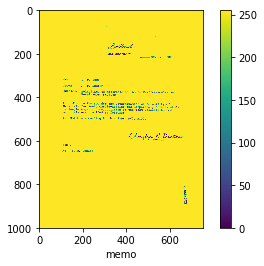

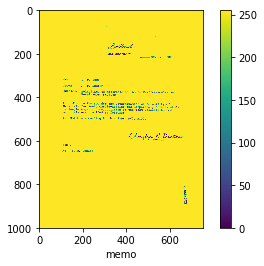

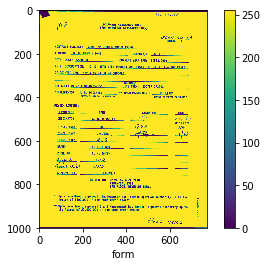

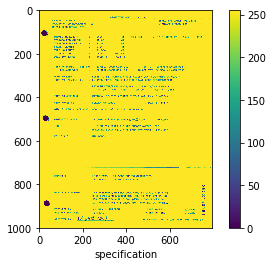

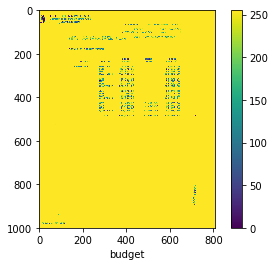

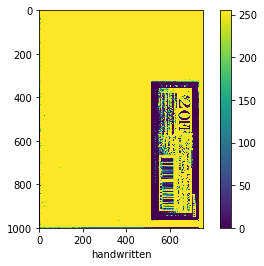

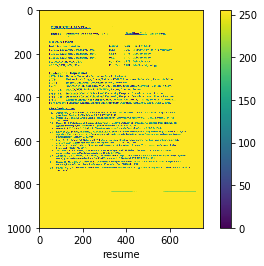

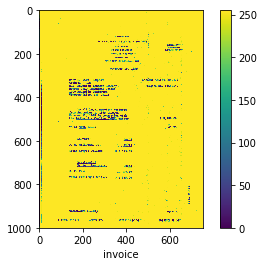

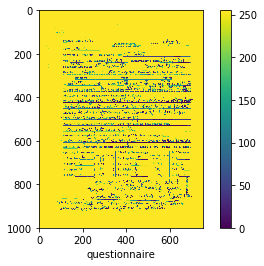

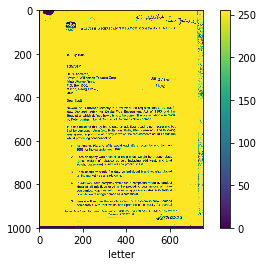

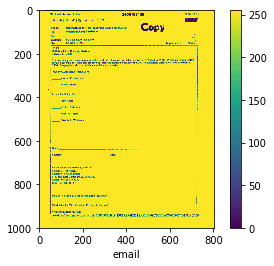

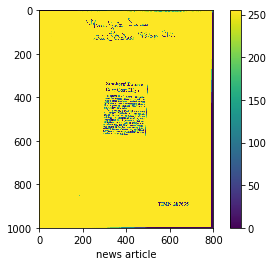

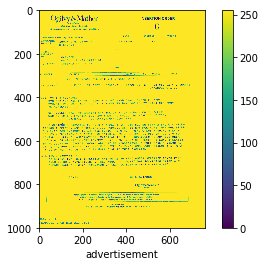

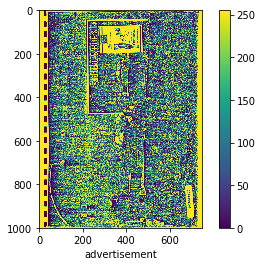

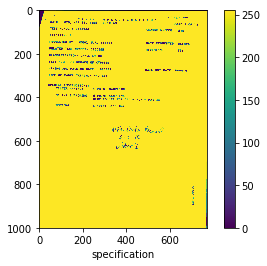

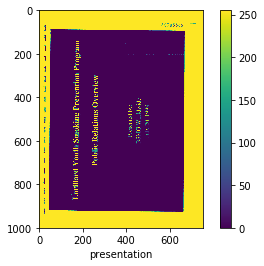

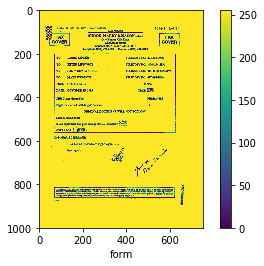

In [10]:
PreviewFile(DataRootFolder, FilePaths.loc[0])
N = 16
Dataset = FilePaths.sample(N)
for i in range(N):
    PreviewFile(DataRootFolder, FilePaths.loc[i])

# 3. ORGANIZING FILES AND SELECTING A SAMPLE

In [11]:
import shutil
import os
from timeit import default_timer as timer
import multiprocessing
import pandas as pd

In [14]:
def CopyImageFiles(FilePaths, SourceDataRootFolder, DestinationRootFolder, LabelDescription):
    FileList = FilePaths.values
    #print(FileList[0])
    for f in FileList:
        SourceFilePath = SourceDataRootFolder+'/'+ f[0] 
        DestinationFolder=DestinationRootFolder+'/{}'.format(LabelDescription[f[1]])
        shutil.copy2(SourceFilePath, DestinationFolder)
        #print(SourceFilePath, '->', DestinationFolder, f[1])
    print(len(FileList))

In [15]:
def CreateistOfSorted(RootDir):
    TargetFolders = ['advertisement',
                     'handwritten',
                     'invoice',
                     'letter',
                     'resume',
                     'scientific publication']
    
    FilesDF= pd.DataFrame()
    
    for folder in TargetFolders:
        FilesList = os.listdir(RootDir+'\\'+folder)
        temp = pd.DataFrame(data=FilesList,columns=['FileName'])
        temp['ClassLabel'] = folder
        FilesDF = FilesDF.append(temp, ignore_index=True)
        
    return FilesDF

In [ ]:
SourceDataRootFolder = r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip\images' 
DestinationRootFolder = r'D:\SourceData\IBM_ADS_Capstone\rvl-cdip_sorted_by_label'
ClassLabels =     ['letter', 'form', 'email', 'handwritten', 'advertisement',
       'scientific report', 'scientific publication', 'specification',
       'file folder', 'news article', 'budget', 'invoice', 'presentation',
       'questionnaire', 'resume', 'memo']

CopyImageFiles(FilePaths, SourceDataRootFolder, DestinationRootFolder, ClassLabels)

# 4. ETL PPROCESS
to load data in model building and application

In [ ]:
import tensorflow as tf
import keras as keras
from keras import backend as K

In [5]:
class ETL:
    def ImageToArray(self, FileName, size=(28,28)):
        
        DocImage=PImage.open(FileName)
        
        DocImage = DocImage.resize(size=size, resample=PIL.Image.BOX)
        
        if DocImage.mode == 'RGBA':
            canvas = PImage.new('RGB', DocImage.size, (255, 255, 255))
            canvas.paste(DocImage, (0, 0), DocImage)
            DocImage = canvas      
              
        if DocImage.mode != 'L':
            DocImage = DocImage.convert('L')  #Convert to greyscale  
        else:
            pass 
        # doc_image.autocontrast https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
        DocImage = ImageOps.autocontrast(DocImage)
        ImageMatrix = np.array(DocImage) 
        DocImage.close()
        return ImageMatrix
    
        
    def TransformImageMatrix(self, X, size=(28,28)):
        img_rows = size[0]
        img_cols =size[1]
        
        if keras.backend.image_data_format() == 'channels_first':
            X = X.reshape(X.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X = X.reshape(X.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
            
        X = X.astype('float32') #convert interger image tensor to float
        X = X/255 # Normalize grayscale to a number between 0 and 1
        
        return X, input_shape
    
    def ETL(self, InputFiles, size=(28,28)):    
        Images = []
        if isinstance(InputFiles, (list, tuple)):
            for f in InputFiles:
                try:
                    Images.append(self.ImageToArray(f, size=size))
                except:
                    Images.append(np.zeros(size))
                    print('Failed to load', f)
        else:
            try:
                Images.append(self.ImageToArray(InputFiles, size=size))
            except:
                Images.append(np.zeros(size))
                print('Failed to load', InputFiles)
            
        Images = np.asarray(list(Images), dtype ='int')
        Images, _ = self.TransformImageMatrix(Images, size=size)
        return Images#, InputFiles

<hr>
<p> This notebook and related materials were developed by <b> Sumudu Tennakoon</b> for the capstone project in partial fulfillment of the requirements for the <b> Advanced Data Science with IBM Specialization</b>. <br>
March 2019. <br>
Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)</p>